In [1]:
from tvb.simulator.simulator import Simulator
from tvb.datatypes.connectivity import Connectivity
from tvb.contrib.inversion.pymcInference import pymcModel

import tvb.simulator.models
import tvb.simulator.integrators
import tvb.simulator.coupling
import tvb.simulator.monitors

import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import pymc3 as pm
import scipy
import theano.tensor as tt
import theano
import math
from tqdm import tqdm
import pickle

%load_ext autoreload
%autoreload 2
%matplotlib inline

/Users/erichter/Documents/Uni/Charite/tvb/tvb-root/scientific_library/tvb/datatypes/surfaces.py:64: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [2]:
# Simulation parameters
with open("../limit-cycle_simulation.pkl", "rb") as f:
    simulation_params = pickle.load(f)

In [3]:
# Connectivity
connectivity = Connectivity()
connectivity.weights = np.array([[0., 2.], [2., 0.]])
connectivity.region_labels = np.array(["R1", "R2"])
connectivity.centres = np.array([[0.1, 0.1, 0.1], [0.2, 0.1, 0.1]])
connectivity.tract_lengths = np.array([[0., 2.5], [2.5, 0.]])
connectivity.configure()

# Model
oscillator_model = getattr(tvb.simulator.models, simulation_params["model"])(
    a=np.asarray([simulation_params["a_sim"]]),
    b=np.asarray([simulation_params["b_sim"]]),
    c=np.asarray([simulation_params["c_sim"]]),
    d=np.asarray([simulation_params["d_sim"]]),
    I=np.asarray([simulation_params["I_sim"]]),
)
oscillator_model.configure()

# Integrator
integrator = getattr(tvb.simulator.integrators, simulation_params["integrator"])(dt=simulation_params["dt"])
integrator.noise.nsig = np.array([simulation_params["nsig"]])
integrator.configure()

# Global coupling
coupling = getattr(tvb.simulator.coupling, simulation_params["coupling"])()

# Monitor
monitor = getattr(tvb.simulator.monitors, simulation_params["monitor"])()

In [4]:
# Simulator
sim = Simulator(
    model=oscillator_model,
    connectivity=connectivity,
    coupling=coupling,
    integrator=integrator,
    monitors=(monitor,),
    simulation_length=simulation_params["simulation_length"]
)

sim.configure()

,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity gid: 3dd14299-8b43-4bf4-8a59-848ab2e46cdc
coupling,Difference gid: 44ac1280-beb1-4970-ad6f-0e90d2736f06
gid,UUID('c42f54a0-28c2-44a2-b303-5582303ac9ff')
initial_conditions,None
integrator,HeunStochastic gid: a9885f42-546a-448e-8fce-7dc3970e3a53
model,Generic2dOscillator gid: d0cc61ea-f7e3-4136-823b-78b5967f6d23
monitors,"(,)"
simulation_length,1000.0


In [5]:
Nt = int(sim.simulation_length)
Nsv = len(sim.model.state_variables)
Nr = sim.connectivity.number_of_regions
Ncv = sim.history.n_cvar
Nc = 1
idmax = sim.connectivity.idelays.max()
cvars = sim.history.cvars

In [66]:
x_init = np.random.rand(Nsv, Nr, 1)
x_init_tensor = theano.shared(x_init)

In [67]:
history_init = np.random.rand(idmax, Nsv, Nr, 1)
history_init_tensor = theano.shared(history_init)

In [69]:
history_init.shape

(1, 2, 2, 1)

In [ ]:
#X_init = np.empty([Nt, Nsv, Nr, 1])
X_init = np.random.rand(Nt, Nsv, Nr, 1)
X_init_tensor = theano.shared(X_init)

In [ ]:
nc_init = np.zeros([Nt, Nc, Nr, 1])
nc_init_tensor = theano.shared(nc_init)

In [ ]:
for it in range(Nt):
    for iT in range(Nr):
        for iS in range(Nr):
            id_ts = sim.connectivity.idelays[iT, iS]
            
            if it - id_ts > 0:
                x_current = X_init[it, cvars, iS, :]
                x_delayed = X_init[it-id_ts, cvars, iT, :]
                nc_init[it, :, iT, :] += sim.connectivity.weights[iT, iS] * sim.coupling.pre(
                    x_current, x_delayed)
            
            elif it-id_ts == 0:
                x_current = X_init[it, cvars, iS, :]
                x_delayed = x_init[cvars, iT, :]
                nc_init[it, :, iT, :] += sim.connectivity.weights[iT, iS] * sim.coupling.pre(
                    x_current, x_delayed)
                
            else:
                x_current = X_init[it, cvars, iS, :]
                x_delayed = history_init[it-id_ts, cvars, iT, :]
                nc_init[it, :, iT, :] += sim.connectivity.weights[iT, iS] * sim.coupling.pre(
                    x_current, x_delayed)
                
            nc_init[it, :, iT, :] = sim.coupling.post(nc_init[it, :, iT, :])

In [ ]:
nc_init_2 = np.zeros([Nt, Nc, Nr, 1])

In [ ]:
for it in range(Nt):
    delayed_indices = (it - sim.connectivity.idelays).flatten()
    
    X_init_bundle = X_init.copy()
    X_init_bundle[0] = x_init
    X_init_bundle[-idmax:] = history_init
        
    X_delayed = X_init_bundle[delayed_indices, cvars, np.repeat(np.arange(Nr), Nr), :].reshape(
        (Nr, Ncv, Nr, 1))
    X_current = X_init[it, cvars, :, :]
        
    nc_init_2[it, :, :, :] = (sim.history.nnz_weights[np.newaxis, :].T * sim.coupling.pre(
        X_current, X_delayed)).sum(axis=2).reshape(Ncv, Nr, 1)
    
    nc_init_2[it, :, :, :] = sim.coupling.post(nc_init_2[it, :, :, :])

In [ ]:
nc_init_3 = np.zeros([Nt, Nc, Nr, 1])
nc_init_3_tensor = theano.shared(nc_init_3)

In [ ]:
for it in range(Nt):
    delayed_indices = (it - sim.connectivity.idelays).flatten()
    
    X_init_tensor = theano.shared(X_init)
    X_init_tensor_bundle = theano.shared(X_init)
    X_init_tensor_bundle = tt.set_subtensor(X_init_tensor_bundle[0], x_init_tensor)
    X_init_tensor_bundle = tt.set_subtensor(X_init_tensor_bundle[-idmax:], history_init_tensor)
        
    X_delayed = X_init_tensor_bundle[delayed_indices, cvars, np.repeat(np.arange(Nr), Nr), :].reshape(
        (Nr, Ncv, Nr, 1))
    X_current = X_init_tensor[it, cvars, :, :]
    
    nc_init_3_tensor = tt.set_subtensor(nc_init_3_tensor[it, :, :, :], 
                                        (sim.history.nnz_weights[np.newaxis, :].T * sim.coupling.pre(
                                            X_current, X_delayed)).sum(axis=2).reshape([Ncv, Nr, 1]))
    
    nc_init_3_tensor = tt.set_subtensor(nc_init_3_tensor[it, :, :, :],
                                        sim.coupling.post(nc_init_3_tensor[it, :, :, :]))

In [ ]:
sim.connectivity.horizon

In [ ]:
sim.coupling._cached_nzr

In [ ]:
it = 1

In [ ]:
c = it

In [ ]:
c = 2
it

In [ ]:
indices = (it - sim.connectivity.idelays)
indices

In [ ]:
indices.flatten()

In [ ]:
indices[np.where(indices == 0)]

In [ ]:
indices = indices[np.where(indices > 0)]
indices

In [ ]:
X_init[indices[np.where(indices == 0)]]

In [ ]:
X_init[0] = x_init

In [ ]:
x_init

In [ ]:
X_init[indices, cvars, np.repeat(np.arange(Nr), Nr), :]

In [ ]:
X_init[it, cvars, :, :]

In [ ]:
n_cvar = sim.history.n_cvar

In [ ]:
diff = X_init[indices, cvars, np.repeat(np.arange(Nr), Nr), :].reshape((Nr, n_cvar, Nr, 1)) - X_init[it, cvars, :, :]

In [ ]:
# diff = diff.sum(axis=2).reshape(n_cvar, Nr, 1)

In [ ]:
nc_init[it, cvars, :, :]

In [ ]:
diff

In [ ]:
(sim.history.nnz_mask * indices)

In [ ]:
weights_ = sim.history.weights

In [ ]:
np.dot(weights_, diff)

In [ ]:
diff.shape

In [ ]:
(sim.history.nnz_weights[np.newaxis, :].T * diff).sum(axis=2).reshape(n_cvar, Nr, 1)

In [ ]:
for it in range(Nt):
    print(sim.connectivity.weights * (it - sim.connectivity.idelays))

In [ ]:
X_init[:, cvars, :, :]

In [ ]:
nc_init

In [6]:
X = simulation_params["simulation"]

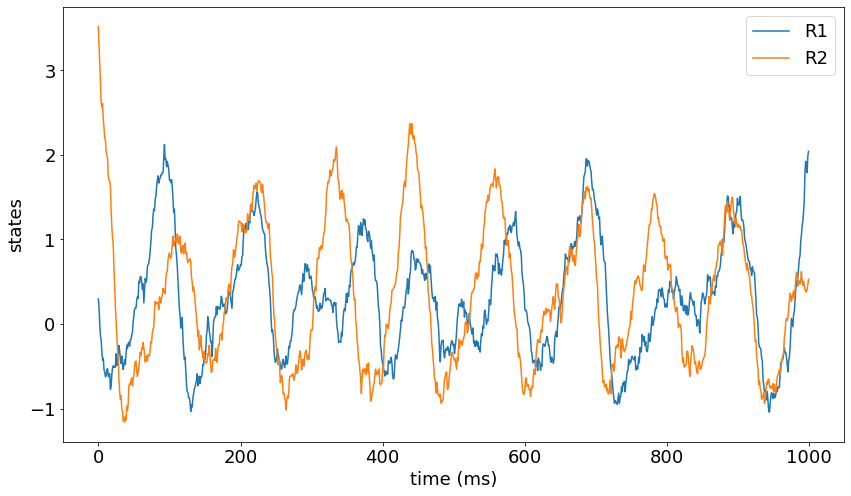

In [7]:
f1 = plt.figure(figsize=(14,8))
plt.plot(X[:, 0, 0, 0], label="R1")
plt.plot(X[:, 0, 1, 0], label="R2")
plt.ylabel("states", fontsize=18)
plt.xlabel("time (ms)", fontsize=18)
plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [8]:
# global inference parameters
shape = X.shape
draws = 500
tune = 500
num_cores = 2

In [272]:
dt = theano.shared(simulation_params["dt"], name="dt")

In [317]:
def scheme(x_eta, *args):
    Nr = sim.connectivity.number_of_regions
    Ncv = sim.history.n_cvar

    x_prev = args[-1]

    x_i = x_prev[sim.model.cvar, :, :]
    x_j = tt.stack(args, axis=0)
    x_j = x_j[:, sim.model.cvar, :, :]
    x_j = x_j[-1 * sim.history.nnz_idelays - 1]
    x_j = x_j[np.arange(sim.history.n_nnzw), :, sim.history.nnz_col_el_idx, :].reshape([Ncv, sim.history.n_nnzw, 1])

    x_i = x_i[:, sim.history.nnz_row_el_idx]
    print(x_i.get_test_value().shape, x_j.get_test_value().shape)

    pre = sim.coupling.pre(x_i, x_j)

    weights_col = sim.history.nnz_weights.reshape((sim.history.n_nnzw, 1))
    sum_ = np.zeros((Ncv, Nr, 1))
    lri, nzr = sim.coupling._lri(sim.history.nnz_row_el_idx)
    print(pre.get_test_value().shape, weights_col.shape, sum_[:, nzr].shape, nzr, lri)
    print(weights_col * pre.get_test_value(), (weights_col * pre.get_test_value()).shape)
    try:
        sum_[:, nzr] = np.add.reduceat(weights_col * pre, lri, axis=1)
        node_coupling = sim.coupling.post(sum_)
    except:
        node_coupling = sim.coupling.post(sum_)
    
    x_next = x_prev + dt
    return x_next

In [318]:
Nt = int(sim.simulation_length)
Nsv = len(sim.model.state_variables)
Nr = sim.connectivity.number_of_regions
Ncv = sim.history.n_cvar
Nc = 1
idmax = sim.connectivity.idelays.max()
cvars = sim.history.cvars

series_init = theano.shared(np.random.rand(*shape))
x_init = theano.shared(np.random.rand(idmax+1, Nsv, Nr, 1))

In [319]:
taps = list(-1 * np.arange(np.unique(sim.history.nnz_idelays).max() + 1) - 1)
x_sim, updates = theano.scan(
    fn=scheme,
    sequences=[series_init],
    outputs_info=[dict(initial=x_init, taps=taps)],
    n_steps=shape[0]
)

(1, 2, 1) (1, 2, 1)
(1, 2, 1) (2, 1) (1, 2, 1) [0 1] [0 1]
[[[-0.274578  ]
  [-0.23607182]]] (1, 2, 1)


### Inference using non-centered model

In [14]:
pymc_model = pymcModel(sim)

In [15]:
with pymc_model.stat_model:
    a_star = pm.Normal(name="a_star", mu=0.0, sd=1.0)
    a = pm.Deterministic(name="a", var=2.0 + a_star)
    
    a_coupling_star = pm.Normal(name="a_coupling_star", mu=0.0, sd=1.0)
    a_coupling = pm.Deterministic(name="coupling", var=0.1 + 0.05 * a_coupling_star)
    
    #x_init = pm.Normal("x_init", mu=0.0, sd=1.0, shape=shape[1:])
    #x_init = theano.shared(X[0], name="x_init")
    
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    
    # sd should be in the range of sqrt(2*nsig)
    noise_gfun_star = BoundedNormal(name="noise_gfun_star", mu=0.0, sd=1.0)
    noise_gfun = pm.Deterministic(name="noise_gfun", var=0.05 + 0.1 * noise_gfun_star)
    
    noise_star = pm.Normal(name="noise_star", mu=0.0, sd=1.0, shape=tuple(shape))
    noise = pm.Deterministic(name="noise", var=noise_gfun * noise_star)
    
    epsilon = BoundedNormal(name="epsilon", mu=0.0, sd=1.0)
    
    # Passing the prior distributions as dictionary. Also including fixed model parameters.
    priors = {
        "model.a": a,
        "model.b": np.array([simulation_params["b_sim"]]),
        "model.c": np.array([simulation_params["c_sim"]]),
        "model.d": np.array([simulation_params["d_sim"]]),
        "model.I": np.array([simulation_params["I_sim"]]),
        "model.tau": np.array([1.0]),
        "model.e": np.array([3.0]),
        "model.f": np.array([1.0]),
        "model.g": np.array([0.0]),
        "model.alpha": np.array([1.0]),
        "model.beta": np.array([1.0]),
        "model.gamma": np.array([1.0]),
        "coupling.a": a_coupling,
        "integrator.noise": noise,
        "global.noise": epsilon,
        "local_coupling": 0.0
    }

In [16]:
pymc_model.prior_stats = {
            "model.a": {"mean": 2.0, "sd": 1.0},
            "coupling.a": {"mean": 0.1, "sd": 0.05},
            "noise_gfun": {"mean": 0.05, "sd": 0.1},
            "global.epsilon": {"mean": 0.0, "sd": 1.0}
        }

In [17]:
pymc_model.set_model(
    priors=priors,
    obs=X, 
    time_step=simulation_params["dt"],
)

In [ ]:
inference_data = pymc_model.run_inference(
    draws=draws,
    tune=tune,
    cores=num_cores,
    target_accept=0.9,
    max_treedepth=20,
    save=True
)

/Users/erichter/Documents/Uni/Charite/tvb/tvb-root/tvb_contrib/tvb/contrib/inversion/pymcInference.py:285: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  self.trace = pm.sample(draws=draws, tune=tune, cores=cores, target_accept=target_accept, max_treedepth=max_treedepth)


In [350]:
pymc_model.inference_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

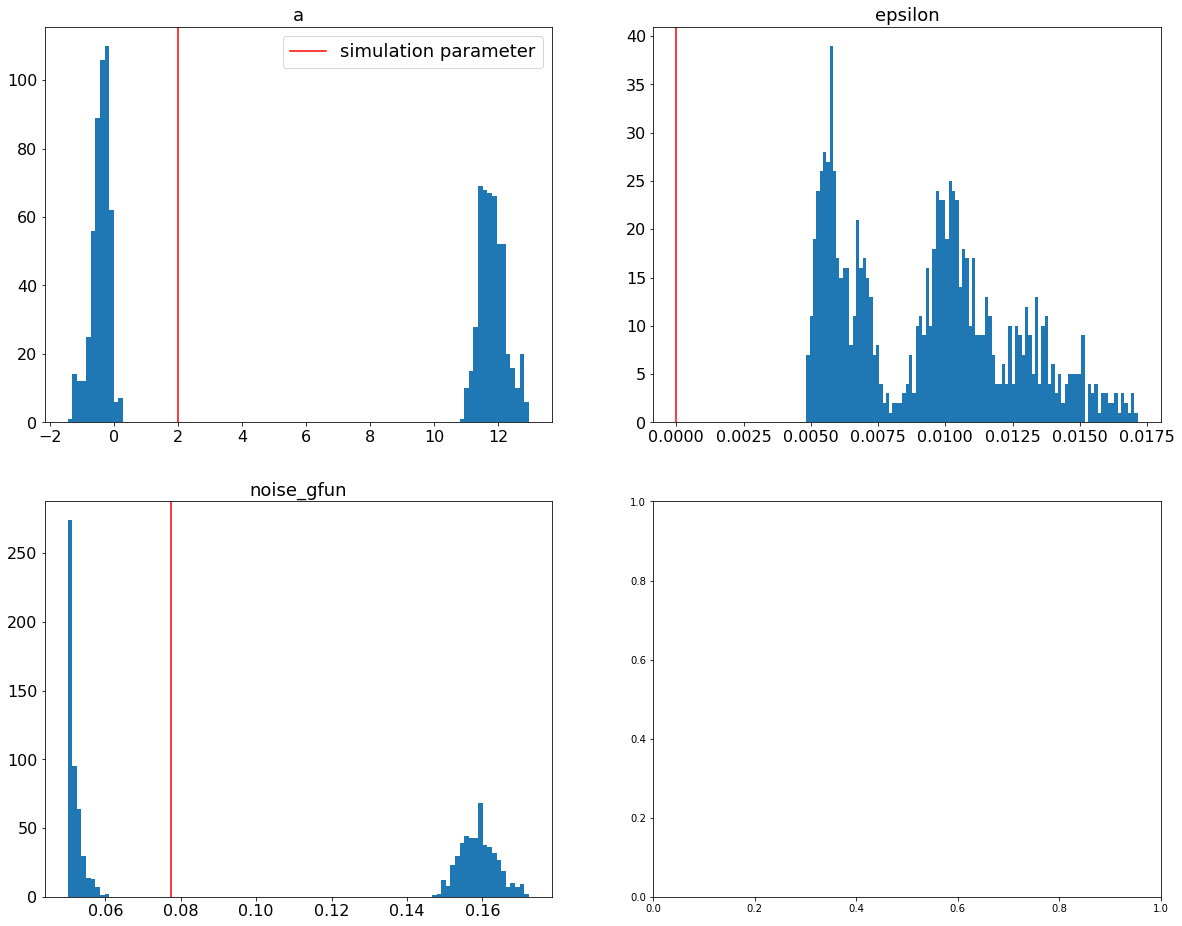

In [351]:
pymc_model.plot_posterior_samples(
    init_params={"a": simulation_params["a_sim"], 
                 "epsilon": 0.0, 
                 "noise_gfun": np.sqrt(2 * simulation_params["nsig"])
                }
)

In [341]:
posterior_x_obs = pymc_model.inference_data.posterior_predictive.x_obs.values.reshape(
    (num_cores*draws, *shape))

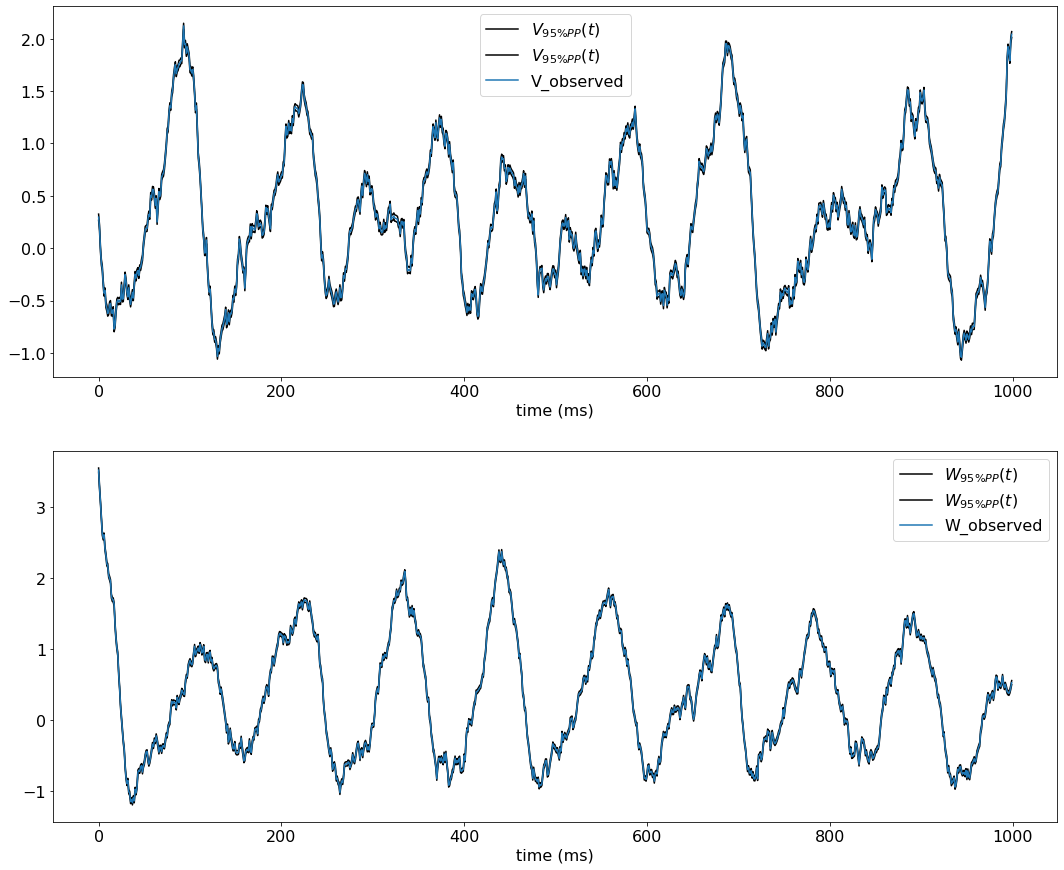

In [344]:
f3, axes3 = plt.subplots(nrows=2, ncols=1, figsize=(18,15))
axes3[0].plot(np.percentile(posterior_x_obs[:, :, 0, 0, 0], [2.5, 97.5], axis=0).T, 
              "k", label=r"$V_{95\% PP}(t)$")
axes3[0].plot(X[:, 0, 0, 0], label="V_observed")
#axes3[0].plot(posterior_x_obs[0, :, 0, 0, 0])
axes3[0].legend(fontsize=16)
axes3[0].set_xlabel("time (ms)", fontsize=16)
axes3[0].tick_params(axis="both", labelsize=16)

axes3[1].plot(np.percentile(posterior_x_obs[:, :, 0, 1, 0], [2.5, 97.5], axis=0).T, 
         "k", label=r"$W_{95\% PP}(t)$")
axes3[1].plot(X[:, 0, 1, 0], label="W_observed")
#axes3[1].plot(posterior_x_obs[0, :, 1, 0, 0])
axes3[1].legend(fontsize=16)
axes3[1].set_xlabel("time (ms)", fontsize=16)
axes3[1].tick_params(axis="both", labelsize=16)

plt.show()

In [ ]:
criteria = ncModel.model_criteria(["WAIC", "LOO"])

In [ ]:
print("WAIC: ", criteria["WAIC"])
print("LOO: ", criteria["LOO"])

In [347]:
pymc_model.summary[pymc_model.summary["r_hat"] > 1.2]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_star,3.695,6.144,-2.963,10.570,4.304,3.633,3.0,27.0,1.88
"noise_star[0, 0, 1, 0]",-1.426,1.675,-4.110,1.318,1.037,0.836,3.0,68.0,1.78
"noise_star[1, 0, 1, 0]",-0.546,1.099,-2.197,1.799,0.524,0.398,5.0,68.0,1.36
"noise_star[2, 0, 1, 0]",-0.137,0.497,-1.038,0.747,0.277,0.217,3.0,75.0,1.65
"noise_star[4, 0, 0, 0]",1.003,0.288,0.502,1.528,0.100,0.073,9.0,76.0,1.21
...,...,...,...,...,...,...,...,...,...
"noise[999, 0, 0, 0]",-0.148,0.051,-0.220,-0.086,0.035,0.029,3.0,77.0,1.83
"noise[999, 0, 1, 0]",-0.074,0.044,-0.132,-0.018,0.030,0.025,3.0,62.0,1.83
epsilon,0.009,0.003,0.005,0.015,0.002,0.002,3.0,16.0,1.86
amplitude,-1.665,0.856,-2.602,-0.768,0.599,0.506,3.0,30.0,1.83


In [352]:
pymc_model.summary.loc[["a", "noise_gfun"]] #, "b", "c", "d", "I"]]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,5.695,6.144,-0.963,12.570,4.304,3.633,3.0,27.0,1.88
noise_gfun,0.105,0.054,0.050,0.165,0.038,0.032,3.0,16.0,1.89


In [354]:
divergent = pymc_model.trace["diverging"]
print("Number of Divergent %d" % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size / len(pymc_model.trace) * 100
print("Percentage of Divergent %.1f" % divperc)
print("Mean tree accept %.1f" % pymc_model.trace['mean_tree_accept'].mean())

Number of Divergent 71
Percentage of Divergent 14.2
Mean tree accept 0.8


In [ ]:
ncModel.save(simulation_params=simulation_params.copy())